<a href="https://colab.research.google.com/github/sabre-code/flower_classification/blob/main/classification_tfds2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import regularizers

SyntaxError: ignored

In [2]:
print(tf.__version__)

2.9.2


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url, fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


In [4]:
image_count = len((list(data_dir.glob('*/*.jpg'))))
print("Total Images: ",image_count)

Total Images:  3670


In [5]:
rose = list(data_dir.glob('roses/*'))
sunflower = list(data_dir.glob('sunflowers/*'))
tulips = list(data_dir.glob('tulips/*'))
dandelion = list(data_dir.glob('dandelion/*'))
daisy = list(data_dir.glob('daisy/*'))

print("Total Roses :",len(rose))
print("Total Sunflowers :",len(sunflower))
print("Total Tulips :",len(tulips))
print("Total Dandelion :",len(dandelion))
print("Total Daisy :",len(daisy))

Total Roses : 641
Total Sunflowers : 699
Total Tulips : 799
Total Dandelion : 898
Total Daisy : 633


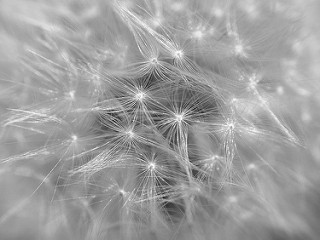

In [6]:
PIL.Image.open(str(dandelion[43]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 7,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
tf.random.set_seed(50)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 7,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


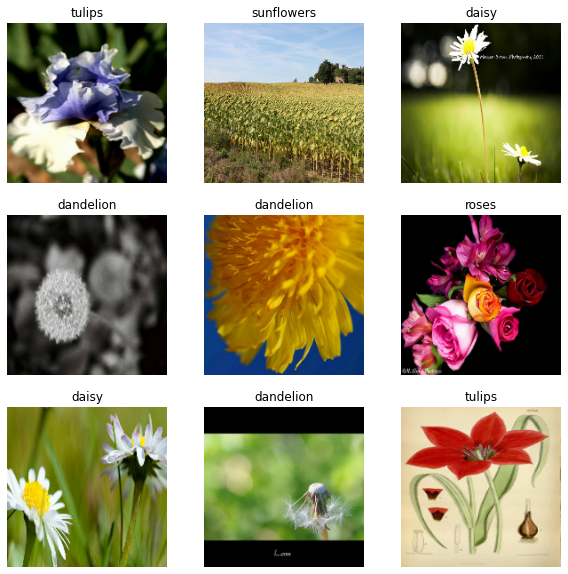

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)


In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3,kernel_regularizer=regularizers.l2(l2=0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, kernel_regularizer=regularizers.l2(0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(128, 3, kernel_regularizer=regularizers.l2(0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [15]:

opt = tf.keras.optimizers.Adam(learning_rate=0.00085)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                      

In [16]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = 50,
  epochs=epochs
)


Epoch 1/50
92/92 [==============================] - 20s 69ms/step - loss: 2.6550 - accuracy: 0.2749 - val_loss: 1.7939 - val_accuracy: 0.4510
Epoch 2/50
92/92 [==============================] - 5s 51ms/step - loss: 1.6403 - accuracy: 0.4656 - val_loss: 1.6499 - val_accuracy: 0.4877
Epoch 3/50
92/92 [==============================] - 5s 50ms/step - loss: 1.5216 - accuracy: 0.5037 - val_loss: 1.5894 - val_accuracy: 0.5109
Epoch 4/50
92/92 [==============================] - 5s 60ms/step - loss: 1.4334 - accuracy: 0.5480 - val_loss: 1.4892 - val_accuracy: 0.5654
Epoch 5/50
92/92 [==============================] - 5s 51ms/step - loss: 1.3732 - accuracy: 0.5708 - val_loss: 1.4031 - val_accuracy: 0.6144
Epoch 6/50
92/92 [==============================] - 5s 51ms/step - loss: 1.3300 - accuracy: 0.5855 - val_loss: 1.4066 - val_accuracy: 0.5872
Epoch 7/50
92/92 [==============================] - 5s 51ms/step - loss: 1.2605 - accuracy: 0.6134 - val_loss: 1.3278 - val_accuracy: 0.6063
Epoch 8/50
9

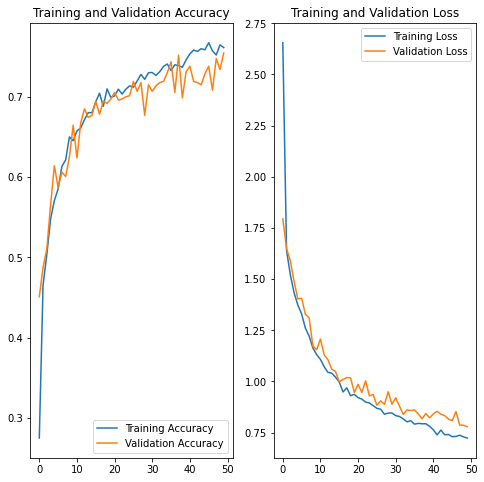

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [18]:
from tensorflow.keras.models import save_model
model.save("saved_model/my_model")

In [34]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
rose_url = "https://i.pinimg.com/originals/65/1b/a1/651ba114732ac1ad16e2dadc04f7483e.jpg"
rose_path = tf.keras.utils.get_file('rose1', origin=rose_url)

img = tf.keras.utils.load_img(
    rose_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(type(predictions))
print(predictions)
score = tf.nn.softmax(predictions[0])
print(type(score))
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 16ms/step
<class 'numpy.ndarray'>
[[-1.5213324   0.60666233  0.71799713  2.3789303   0.10855136]]
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0.01364186 0.11456452 0.12805668 0.6741187  0.06961828], shape=(5,), dtype=float32)
This image most likely belongs to sunflowers with a 67.41 percent confidence.


In [25]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 14.1 MB/s 
     |████████████████████████████████| 84 kB 4.5 MB/s 
     |████████████████████████████████| 2.3 MB 55.0 MB/s 
     |████████████████████████████████| 213 kB 70.7 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 106 kB 71.1 MB/s 
     |████████████████████████████████| 272 kB 63.7 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 80 kB 10.1 MB/s 
     |████████████████████████████████| 68 kB 8.3 MB/s 
     |████████████████████████████████| 68 kB 8.7 MB/s 
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 46 kB 4.3

In [41]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/models/myModel.hdf5')

In [40]:
from google.colab import files
files.download("saved_model/my_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [37]:
import gradio as gr

def classify(inp):
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  confidences = {class_names[i]: float(score[i]) for i in range(5)}
  return confidences

gr.Interface(fn=classify, 
             inputs=gr.Image(shape=(180, 180)),
             outputs=gr.Label(num_top_classes=5)).launch(debug=True)
            

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 18ms/step
Keyboard interruption in main thread... closing server.


In [20]:
from tensorflow.keras.models import save_model
model.save("saved_model/my_model")

In [21]:
https://docs.google.com/document/d/1YtIdpRkkUvCOPPDqI7jGpW5h6d526XZGEattmqpaDj8/edit?usp=drivesdk

SyntaxError: ignored